In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
pd.set_option('display.float_format', '{:.2f}'.format)

In [71]:
def get_db_connection():
    """Создает подключение к PostgreSQL"""
    try:
        conn = psycopg2.connect(
            host='localhost',
            port=5432,
            database='game_platform',
            user='postgres',
            password='postgres'
        )
        print("Подключение к PostgreSQL установлено")
        return conn
    except Exception as e:
        print(f"Ошибка подключения: {e}")
        return None

conn = get_db_connection()

Подключение к PostgreSQL установлено


In [72]:
query = """
SELECT 
    (SELECT COUNT(*) FROM clients) as total_clients,
    (SELECT COUNT(*) FROM games) as total_games,
    (SELECT SUM(amount) FROM transactions) as total_revenue
"""

stats_df = pd.read_sql_query(query, conn)
stats_df

,total_clients,total_games,total_revenue
0,12240,19,28865.00


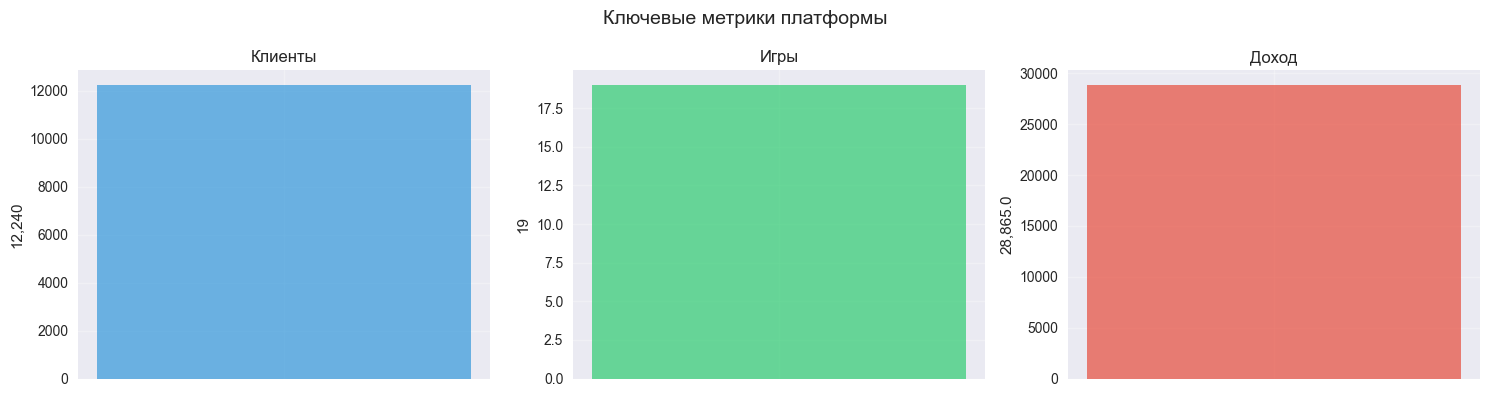

In [73]:
# Визуализация базовых метрик
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['total_clients', 'total_games', 'total_revenue']
titles = ['Клиенты', 'Игры', 'Доход']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, (col, title, color) in enumerate(zip(metrics, titles, colors)):
    value = stats_df[col][0]
    axes[idx].bar([''], [value], color=color, alpha=0.7)
    axes[idx].set_title(f'{title}')
    axes[idx].set_ylabel(f'{value:,}')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Ключевые метрики платформы', fontsize=14)
plt.tight_layout()
plt.show()

In [74]:
# динамика доходов по дням
query = """
SELECT 
    DATE(transaction_date) as day,
    SUM(amount) as total_revenue,
    COUNT(*) as transactions_count
FROM transactions
GROUP BY DATE(transaction_date)
ORDER BY day DESC
LIMIT 30
"""

daily_revenue = pd.read_sql_query(query, conn)
daily_revenue['day'] = pd.to_datetime(daily_revenue['day'])

daily_revenue = daily_revenue.sort_values('day')
daily_revenue.head()

,day,total_revenue,transactions_count
20,2026-01-24,1806.55,146
19,2026-01-25,1556.19,152
18,2026-01-26,1667.38,175
17,2026-01-27,1342.04,111
16,2026-01-28,1066.90,120


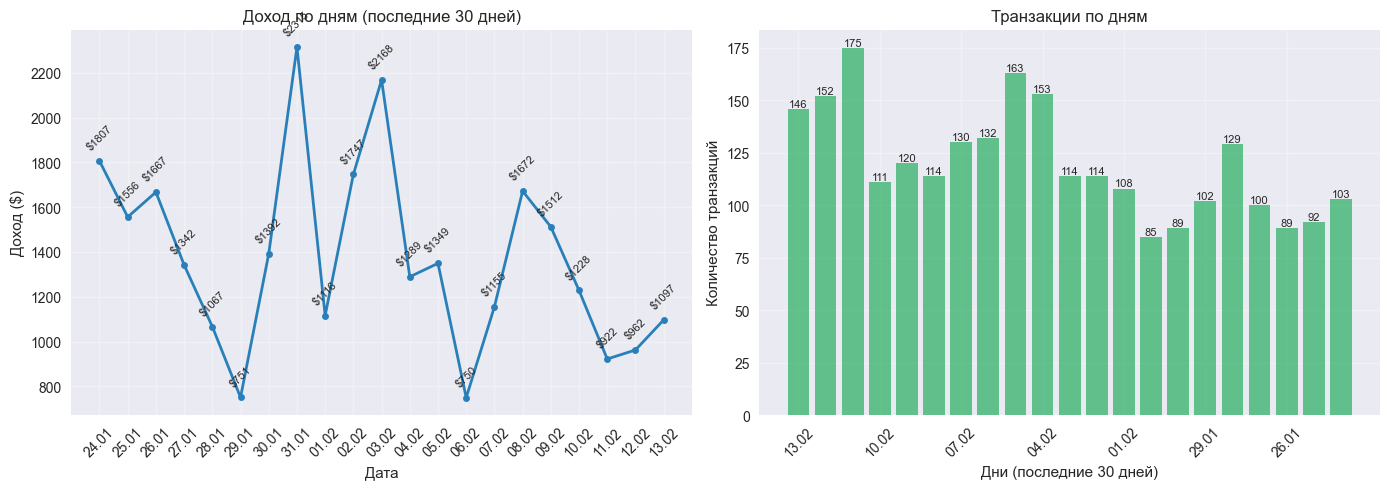

In [75]:
# График доходов по дням
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(daily_revenue['day'], daily_revenue['total_revenue'], 
         marker='o', linewidth=2, color='#2980b9', markersize=5)
plt.title('Доход по дням (последние 30 дней)')
plt.xlabel('Дата')
plt.ylabel('Доход ($)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

if not daily_revenue.empty:
    dates = daily_revenue['day'].dt.strftime('%d.%m')
    plt.xticks(daily_revenue['day'], dates, rotation=45)
    
    for idx, row in daily_revenue.iterrows():
        plt.annotate(f"${row['total_revenue']:.0f}", 
                    xy=(row['day'], row['total_revenue']), 
                    xytext=(0, 8), textcoords='offset points',
                    ha='center', fontsize=8, fontweight='normal',
                    rotation=45)

plt.subplot(1, 2, 2)
bars = plt.bar(range(len(daily_revenue)), daily_revenue['transactions_count'], 
               color='#27ae60', alpha=0.7)
plt.title('Транзакции по дням')
plt.xlabel('Дни (последние 30 дней)')
plt.ylabel('Количество транзакций')
plt.grid(True, alpha=0.3)

if not daily_revenue.empty:
    if len(daily_revenue) <= 15:
        plt.xticks(range(len(daily_revenue)), dates, rotation=45)
    else:
        indices = range(0, len(dates), 3)
        plt.xticks(indices, [dates[i] for i in indices], rotation=45)
    
    for idx, (bar, row) in enumerate(zip(bars, daily_revenue.itertuples())):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [76]:
# активность пользователей по странам
query = """
SELECT 
    country_code,
    COUNT(*) as users_count,
    AVG(total_spent) as avg_spent
FROM clients
GROUP BY country_code
HAVING COUNT(*) >= 5
ORDER BY users_count DESC
LIMIT 10
"""

countries_df = pd.read_sql_query(query, conn)
countries_df

,country_code,users_count,avg_spent
0,US,2251,2.43
1,CN,1866,2.32
2,RU,1568,2.04
3,DE,909,2.43
4,BR,718,2.67
5,FR,632,2.21
6,GB,592,2.31
7,TR,584,2.06
8,PL,510,2.51
9,CA,422,2.27


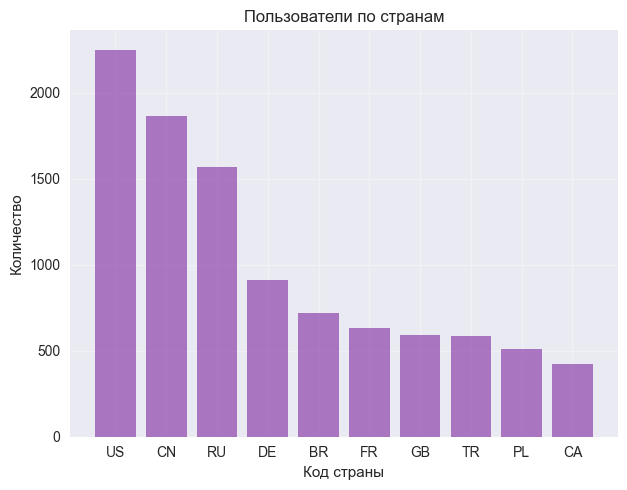

In [77]:
# График пользователей по странам
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(countries_df['country_code'], countries_df['users_count'], 
        color='#8e44ad', alpha=0.7)
plt.title('Пользователи по странам')
plt.xlabel('Код страны')
plt.ylabel('Количество')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [78]:
# распределение игр по жанрам
query = """
SELECT 
    genre_main,
    COUNT(*) as games_count,
    AVG(current_price) as avg_price
FROM games
WHERE is_active = TRUE
GROUP BY genre_main
ORDER BY games_count DESC
"""

genres_df = pd.read_sql_query(query, conn)
genres_df.head(8)

,genre_main,games_count,avg_price
0,Shooter,4,7.16
1,Adventure,4,11.54
2,Strategy,3,3.44
3,Role-Playing (RPG),2,29.93
4,Racing,2,25.18
5,Action,2,6.66
6,Simulation,1,10.38
7,Puzzle,1,0.00


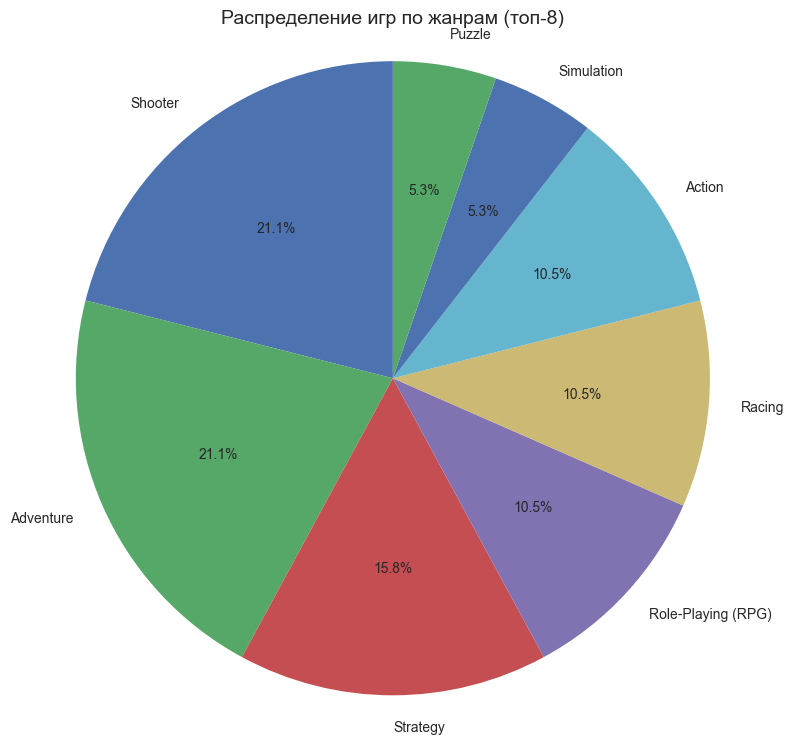

In [79]:
# Круговая диаграмма жанров
plt.figure(figsize=(9, 9))
plt.pie(genres_df['games_count'].head(8), 
        labels=genres_df['genre_main'].head(8), 
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10})
plt.title('Распределение игр по жанрам (топ-8)', fontsize=14)
plt.axis('equal')
plt.show()

In [80]:
# 3. топ-5 игр по продажам
query = """
SELECT 
    g.title,
    g.genre_main,
    g.total_purchases as sales,
    g.current_price,
    d.studio_name
FROM games g
JOIN developers d ON g.developer_id = d.developer_id
WHERE g.is_active = TRUE
ORDER BY g.total_purchases DESC
LIMIT 5
"""

top_games = pd.read_sql_query(query, conn)
top_games

,title,genre_main,sales,current_price,studio_name
0,Colossus Star,Puzzle,188,0.00,Divine Development
1,Project Music,Adventure,178,20.68,Studio Cavern
2,Lunar Ninja,Simulation,175,10.38,Humble Works Inc.
3,Operation Illusion,Role-Playing (RPG),173,20.15,Essence Productions
4,Legacy of the Spirit,Shooter,165,1.00,Purple Works


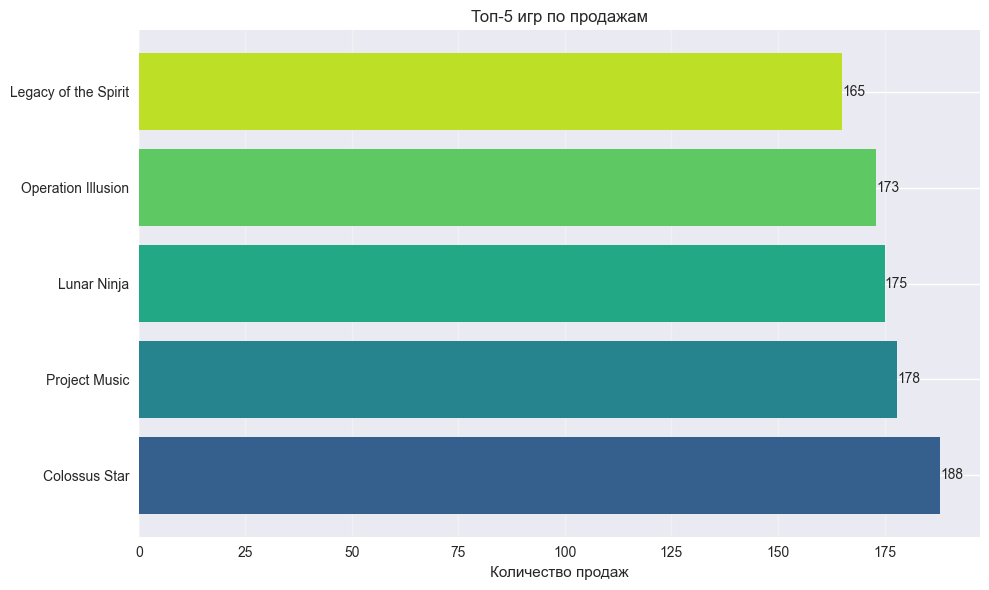

In [81]:
# Визуализация топ-игр
plt.figure(figsize=(10, 6))
bars = plt.barh(top_games['title'], top_games['sales'], 
                color=plt.cm.viridis(np.linspace(0.3, 0.9, 5)))
plt.xlabel('Количество продаж')
plt.title('Топ-5 игр по продажам')
plt.grid(True, alpha=0.3, axis='x')

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', ha='left', va='center')

plt.tight_layout()
plt.show()

In [82]:
# Данные о топ-10 разработчиках
query = """
SELECT 
    d.studio_name,
    COUNT(g.game_id) as games_count,
    SUM(g.total_purchases) as total_sales
FROM developers d
LEFT JOIN games g ON d.developer_id = g.developer_id
GROUP BY d.studio_name
HAVING COUNT(g.game_id) > 0
ORDER BY total_sales DESC
LIMIT 10
"""

devs_df = pd.read_sql_query(query, conn)
devs_df

,studio_name,games_count,total_sales
0,Team Hidden Ltd.,3,463
1,Essence Productions,3,380
2,Divine Development,2,331
3,Humble Works Inc.,2,289
4,Salmon Creations,2,272
5,Temple Interactive,2,220
6,Team Labyrinth Corp.,2,182
7,Studio Cavern,1,178
8,Purple Works,1,165
9,Silver Purple Works Inc.,1,131


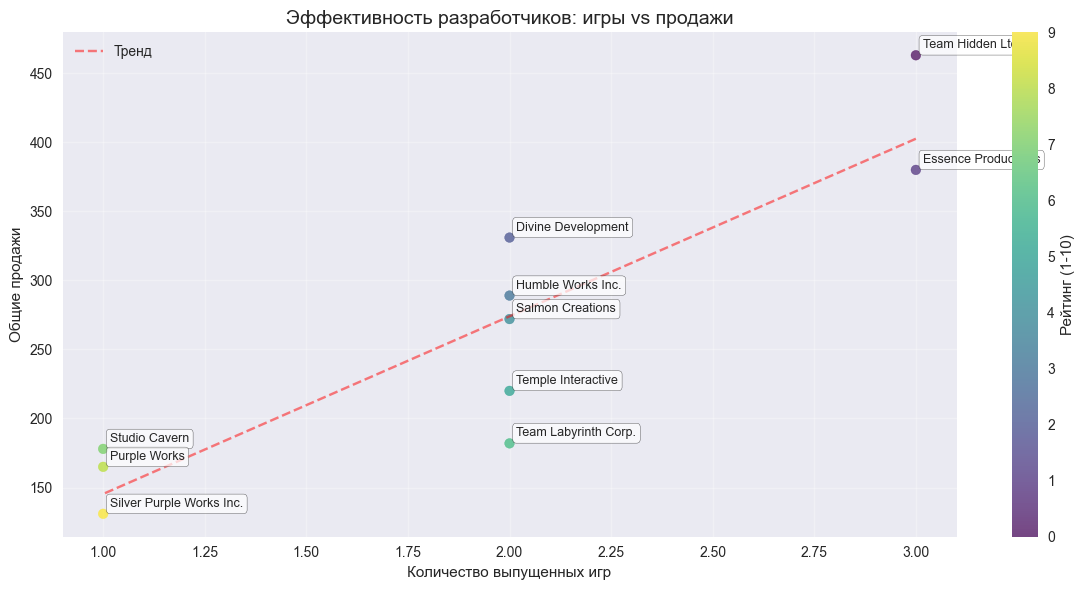

In [83]:
# графика для анализа разработчиков
plt.figure(figsize=(12, 6))

scatter = plt.scatter(devs_df['games_count'], 
                      devs_df['total_sales'], 
                      alpha=0.7,
                      c=range(len(devs_df)),
                      cmap='viridis')

for idx, row in devs_df.iterrows():
    plt.annotate(row['studio_name'], 
                xy=(row['games_count'], row['total_sales']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.xlabel('Количество выпущенных игр')
plt.ylabel('Общие продажи')
plt.title('Эффективность разработчиков: игры vs продажи', fontsize=14)
plt.grid(True, alpha=0.3)

if len(devs_df) > 1:
    z = np.polyfit(devs_df['games_count'], devs_df['total_sales'], 1)
    p = np.poly1d(z)
    plt.plot(devs_df['games_count'], p(devs_df['games_count']), 
             "r--", alpha=0.5, label='Тренд')

plt.legend()
plt.colorbar(scatter, label='Рейтинг (1-10)')
plt.tight_layout()
plt.show()

In [84]:
# Итоги
print("=" * 50)
print("Итоги")
print("=" * 50)

print(f"\nКлиентов всего: {stats_df['total_clients'][0]:,}")
print(f"Игр в каталоге: {stats_df['total_games'][0]:,}")
print(f"Общий доход: ${stats_df['total_revenue'][0]:,.2f}")

print(f"\nТоповая игра: {top_games['title'].iloc[0]}")
print(f"Продаж: {top_games['sales'].iloc[0]:,}")
print(f"Разработчик: {top_games['studio_name'].iloc[0]}")

print(f"\nСамые активные страны:")
for idx, row in countries_df.head(3).iterrows():
    print(f"   {row['country_code']}: {row['users_count']} пользователей")

print(f"\nПопулярный жанр: {genres_df['genre_main'].iloc[0]}")
print(f"Игр в жанре: {genres_df['games_count'].iloc[0]}")


Итоги

Клиентов всего: 12,240
Игр в каталоге: 19
Общий доход: $28,865.00

Топовая игра: Colossus Star
Продаж: 188
Разработчик: Divine Development

Самые активные страны:
   US: 2251 пользователей
   CN: 1866 пользователей
   RU: 1568 пользователей

Популярный жанр: Shooter
Игр в жанре: 4
